In [115]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from pandas.io.data import DataReader

from datetime import datetime

from __future__ import division


Lets us analyse the following O&G stocks 


In [54]:
stocks = ['COG','SWN','SGY','CHK']
end = datetime.now()
start = datetime(end.year - 1,end.month,end.day)

#Getting the stocks
for stock in stocks:   
    # Set DataFrame as the Stock Ticker
    globals()[stock] = DataReader(stock,'yahoo',start,end)


In [55]:
COG.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-06-01,33.910000,34.259998,33.849998,34.139999,5246800,34.019584
2015-06-02,34.209999,34.419998,33.860001,34.169998,4340400,34.049477
2015-06-03,34.080002,34.330002,33.910000,34.139999,5920000,34.019584
2015-06-04,34.000000,34.279999,33.959999,34.110001,8913400,33.989691
2015-06-05,33.849998,34.369999,33.799999,33.849998,7292200,33.730606


In [56]:
SWN.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-06-01,25.670000,25.879999,25.270000,25.469999,5770300,25.469999
2015-06-02,25.389999,25.660000,24.959999,25.170000,7245700,25.170000
2015-06-03,25.250000,25.440001,24.889999,24.950001,6035700,24.950001
2015-06-04,24.639999,24.959999,24.299999,24.540001,7216700,24.540001
2015-06-05,24.370001,24.900000,24.170000,24.370001,5809100,24.370001


In [57]:
SGY.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-06-01,13.55,13.60,13.16,13.25,561900,13.25
2015-06-02,13.43,14.29,13.41,13.82,963200,13.82
2015-06-03,13.68,14.30,13.55,13.77,795200,13.77
2015-06-04,13.63,13.71,13.35,13.43,535200,13.43
2015-06-05,13.28,14.17,13.22,13.73,605800,13.73


In [58]:
CHK.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-06-01,14.11,14.14,13.86,13.86,17904400,13.86
2015-06-02,13.91,14.10,13.85,14.05,20554400,14.05
2015-06-03,13.93,13.98,13.44,13.56,34225900,13.56
2015-06-04,13.42,13.47,12.98,13.04,33066400,13.04
2015-06-05,13.01,13.26,12.89,13.15,26258900,13.15


In [59]:
closing_df = DataReader(['COG','SWN','SGY','CHK'],'yahoo',start,end)['Adj Close']
volume_df = DataReader(['COG','SWN','SGY','CHK'],'yahoo',start,end)['Volume']

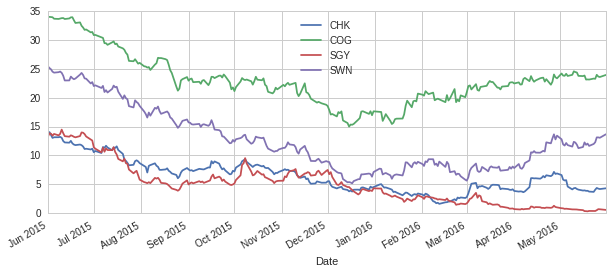

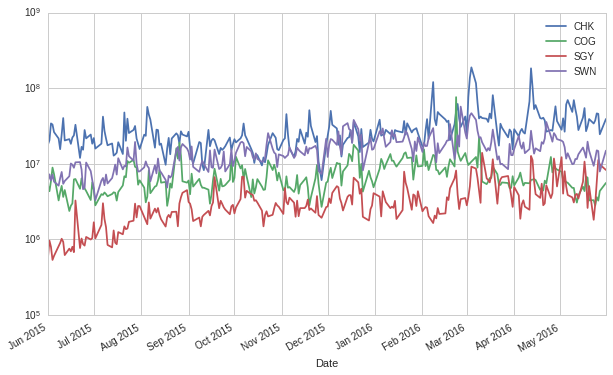

In [60]:
closing_df.plot(legend = True, figsize = (10,4))
volume_df.plot(legend = True, figsize = (10,6), logy = True)

Getting the returns




In [61]:
returns = closing_df.pct_change().dropna()
returns.head()

,CHK,COG,SGY,SWN
Date,,,,
2015-06-02,0.013709,0.000879,0.043019,-0.011779
2015-06-03,-0.034875,-0.000878,-0.003618,-0.008741
2015-06-04,-0.038348,-0.000879,-0.024691,-0.016433
2015-06-05,0.008436,-0.007622,0.022338,-0.006927
2015-06-08,0.000760,-0.001182,-0.018208,0.003283


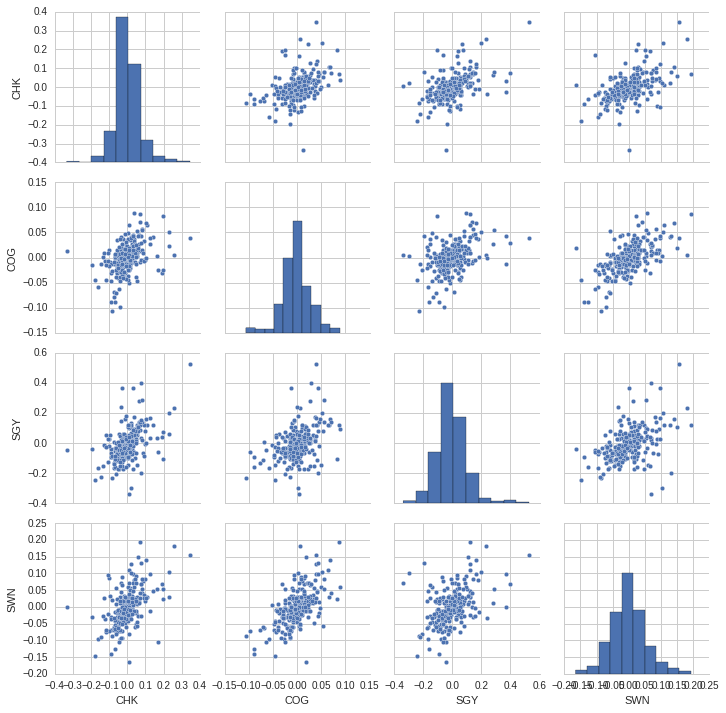

In [62]:
sns.pairplot(returns)

As we can see, there seems to be a fair amount of correlation between the selected stocks. This is expected since these are stocks are part of the same industry. In practice, it is recommended NOT to maintain a portfolio with such correlation in order to keep the portfolio immune to sudden market changes in a certain industry




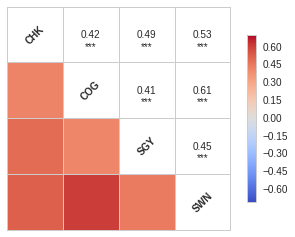

In [63]:
sns.corrplot(returns.dropna(), annot = True)

The above plot makes the correlation clearer

#### Lets calculate the Risk associated with buying the above stocks


The simplest way to calculate such risk is by comparing the means of these returns with their standard deviation as follows


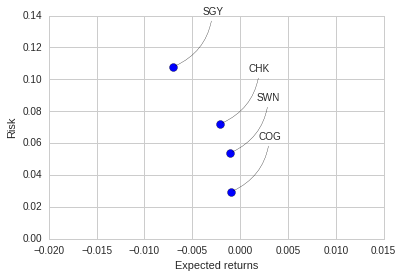

In [66]:
returns = returns.dropna()
pointsize = np.pi*20
plt.scatter(returns.mean(),returns.std(),s = pointsize)
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(returns.columns, returns.mean(), returns.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (50, 50),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=-0.3'))

From the above we can observe that SWN and COG are stable-ish since they bring in close to no return, SGY should be avoided as it is extremely high risk with low returns. CHK lies in somewhat same area of SWN and COG, but seeing as it is of higher risk with lower returns than SWN and COG, we will avoid it for the rest of this analysis. 

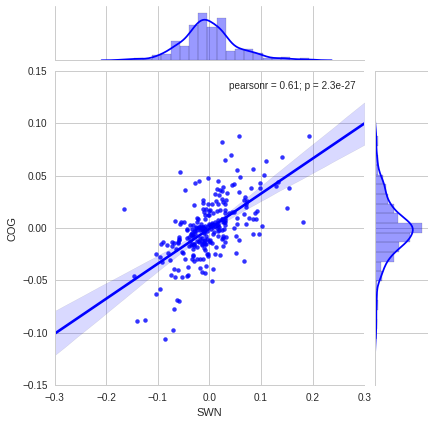

In [83]:
sns.jointplot(returns['SWN'],returns['COG'], kind = 'reg', color = 'blue')

Hence, let us dive deeper and analyse risk of SWN and COG stocks using Quantile and Monte Carlo Methods

### SWN

#### Quantile Method


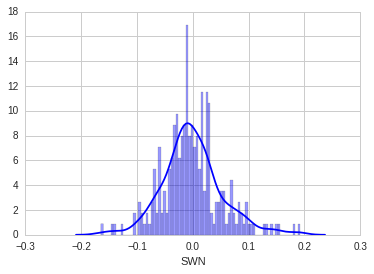

In [130]:
sns.distplot(returns['SWN'], bins = 80 , color = 'blue')

In [76]:
returns['SWN'].quantile(0.05)

-0.081072123690930559

From the histogram, we can see our VaR (Value at Risk) with 95% confidence at 5% VaR per day is 8.1% of our investment


#### Monte Carlo Method (uses GBM)

Let us first define the variables for the GBM model 

In [84]:
days = 365
dt = 1/365
mu = returns['SWN'].mean()
sigma = returns['SWN'].std()

Let us define the function for the geometric Brownian Motion within our Monte Carlo Simulation
![alt text](http://i.investopedia.com/inv/articles/site/CT-MonteCarlo2r.gif)

In [94]:
def monte_carlo_simulation(start_price,days,mu,sigma):
    
    price = np.zeros(days)
    price[0] = start_price
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for day in xrange(1,days):
        # we will center our random distribution around the drift value
        shock[day] = np.random.normal(loc = mu * dt, scale = sigma * np.sqrt(dt))
        # defining our drift
        drift[day] = mu * dt
        # our price 
        price[day] = price[day-1] + (price[day-1] * (drift[day] + shock[day]))
    
    
    return price

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-06-01,25.670000,25.879999,25.270000,25.469999,5770300,25.469999
2015-06-02,25.389999,25.660000,24.959999,25.170000,7245700,25.170000
2015-06-03,25.250000,25.440001,24.889999,24.950001,6035700,24.950001
2015-06-04,24.639999,24.959999,24.299999,24.540001,7216700,24.540001
2015-06-05,24.370001,24.900000,24.170000,24.370001,5809100,24.370001


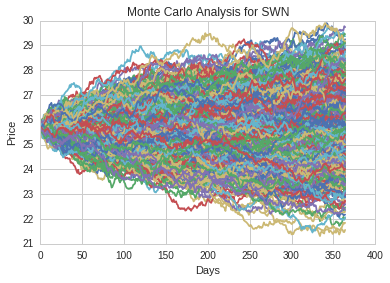

In [110]:
start_price = 25.67
for run in xrange(1000):
    plt.plot(monte_carlo_simulation(start_price,days,mu,sigma))
    
plt.xlabel("Days")
plt.ylabel("Price")  
plt.title('Monte Carlo Analysis for SWN')

Although the above plot looks like a huge mess, it indicates 1000 possible variations in which the stock could move across the given time window using GBM. (By industry standard, 1000 is quite a small run sample).
We will now generate a histogram with much larger run to get a quantile that indiciates the VaR.

In [111]:
runs = 10000
simulations = np.zeros(runs)
np.set_printoptions(threshold = 5)
for run in xrange(runs):
    simulations[run] = monte_carlo_simulation(start_price,days,mu,sigma)[days-1]

In [116]:
p_99 = np.percentile(simulations,1)
p_99

22.64968132975444

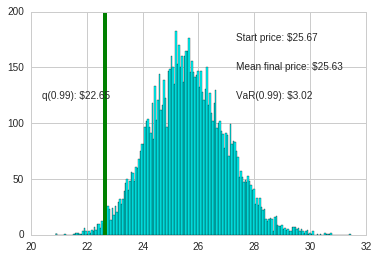

In [134]:
plt.hist(simulations,bins = 200, color = 'cyan')

plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price)

plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations.mean())

plt.figtext(0.6, 0.6, "VaR(0.99): $%.2f" % (start_price - p_99))

plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % p_99)

plt.axvline(x=p_99, linewidth=4, color='g')

### COG

#### Quantile Method 

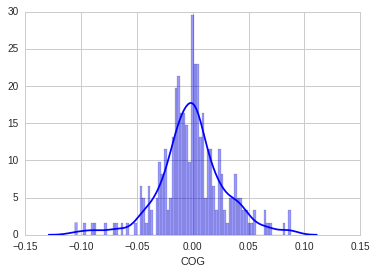

In [138]:
sns.distplot(returns['COG'], bins = 80,color = 'blue')

In [139]:
returns['COG'].quantile(0.05)

-0.04570003456373456

From the histogram, we can see our VaR (Value at Risk) with 95% confidence at 5% VaR per day is 4.5% of our investment


#### Monte Carlo Method

In [140]:
COG.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-06-01,33.910000,34.259998,33.849998,34.139999,5246800,34.019584
2015-06-02,34.209999,34.419998,33.860001,34.169998,4340400,34.049477
2015-06-03,34.080002,34.330002,33.910000,34.139999,5920000,34.019584
2015-06-04,34.000000,34.279999,33.959999,34.110001,8913400,33.989691
2015-06-05,33.849998,34.369999,33.799999,33.849998,7292200,33.730606


In [143]:
start_price = 33.91
mu = returns['COG'].mean()
sigma = returns['COG'].std()
days = 365
dt = 1/365

In [145]:
runs = 10000
simulations = np.zeros(runs)
for run in xrange(runs):
    simulations[run] = monte_carlo_simulation(start_price,days,mu,sigma)[days-1]

In [147]:
p_99 = np.percentile(simulations,1)
p_99

31.561486569979891

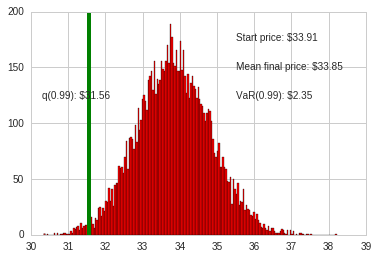

In [149]:
plt.hist(simulations, bins = 200, color = 'red')

plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price)

plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations.mean())

plt.figtext(0.6, 0.6, "VaR(0.99): $%.2f" % (start_price - p_99))

plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % p_99)

plt.axvline(x=p_99, linewidth=4, color='g')

In [150]:
#Copyright Adithya Murali, 2016